In [1]:
%matplotlib inline
import glob
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from astropy.io import fits
from scipy.optimize import curve_fit,leastsq
from scipy import stats
from sklearn.mixture import GaussianMixture as GMM
from scipy.fftpack import fft,ifft,dct,idct
#import warnings
import matplotlib as mpl
#warnings.filterwarnings('ignore')
import time
import csv
import datetime
import time
from pixelcorrection import compute_sv
from astropy.stats import sigma_clip
from astroML.plotting import hist
import itertools
import operator

plt.style.use('seaborn-white')
mpl.rcParams.update({'font.size': 18})

ImportError: No module named 'pixelcorrection'

In [3]:
imdir = "results_v3/"
lograte_regions = np.linspace(-2.5,1,15)
region_rates = [np.array([]) for _ in range(len(lograte_regions))]
region_errs = [np.array([]) for _ in range(len(lograte_regions))]
dt_mid = []



for file in glob.glob(imdir+"*"):
    f_name = file.split("/")[-1]
    f_dates= f_name.split(".")[0]
    y_start,m_start,y_end,m_end = f_dates.split("_")
    
    dt_start = dt.datetime(int(y_start),int(m_start),1)  
    dt_end = dt.datetime(int(y_end),int(m_end),1)
    delta = dt_end-dt_start
    dt_mid.append(dt_start+delta/2)
        
    

    data = pd.read_csv(file,header=None)
    for idx, row in enumerate(data.itertuples()):
        region_rates[idx] = np.append(region_rates[idx],row[2])
        region_errs[idx] = np.append(region_errs[idx],row[3])

            
dt_stamps = [mid.timestamp()/3600/24/365+1970 for mid in dt_mid]

In [4]:
scalevalues = np.array(region_rates)
datetimes = np.array(dt_mid)
darkrate_bins = np.array(lograte_regions)

In [5]:
test = np.array((scalevalues,datetimes))

/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/scipy/optimize/minpack.py:779: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


(300,)
(300,)
[-1.97993501  4.649985    4.53816877  0.24677732  1.24545931]


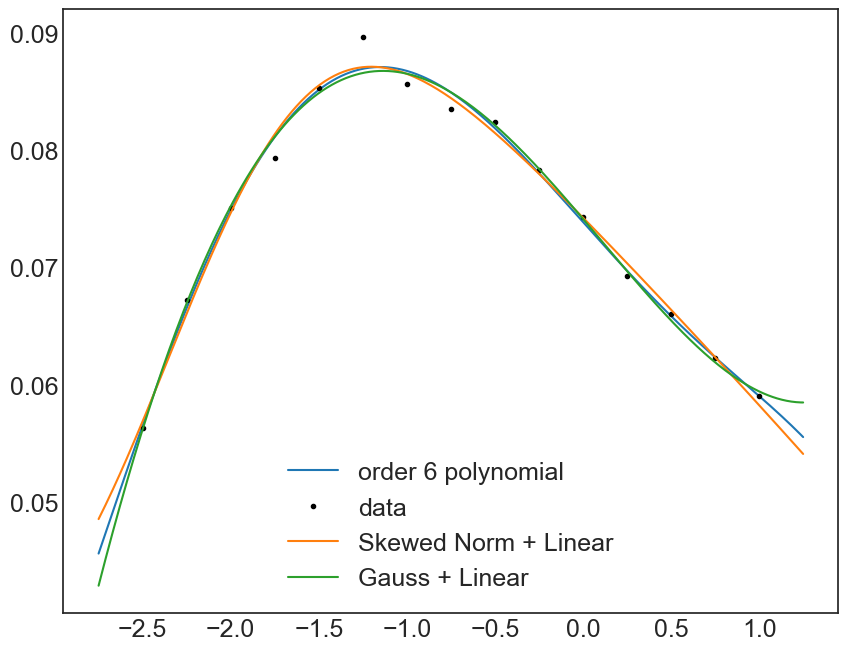

In [6]:
#Try polynomial

n=6
data = scalevalues.T[25]
fitspace = np.linspace(-2.75,1.25,300)

fit, C_p =  np.polyfit(darkrate_bins,data,n,cov=True)
p = np.poly1d(fit)
fig, ax = plt.subplots(figsize=(10,8))
fig.dpi = 100

ax.plot(fitspace,p(fitspace),label='order {} polynomial'.format(n))
ax.plot(darkrate_bins,data,".", label = "data",color='k')

#Try skewed norm + linear

def skewnorm(x,*p):
    loc,scale,a,c,d,e=p
    t = (x-loc) / scale
    return 2 / scale * stats.norm.pdf(t) * stats.norm.cdf(a*t) + c*x + e

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [-1.7, 4, 7.55,0.05,0.05,0.02]
coeff, var_matrix = curve_fit(skewnorm, darkrate_bins, data, p0=p0)

# Get the fitted curve
hist_fit = skewnorm(fitspace, *coeff)
print(np.shape(hist_fit))
ax.plot(fitspace,hist_fit,label = "Skewed Norm + Linear")
ax.legend()
ax.grid()

#Try Gauss + linear
def gauss(x, *p):
    A, mu, sigma,c,e = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2)) + c*x + e
p0 = [-1.7, 4, 7.55,0.05,0.05]
coeff, var_matrix = curve_fit(gauss, darkrate_bins, data, p0=p0)

# Get the fitted curve
hist_fit = gauss(fitspace, *coeff)
print(np.shape(hist_fit))
ax.plot(fitspace,hist_fit,label = "Gauss + Linear")
ax.legend()
ax.grid()

print(coeff)

In [7]:
#Skewed Norm + Linear

# Define model function to be used to fit to the data above:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))
def skewnorm(x,*p):
    loc,scale,a,c,d=p
    t = (x-loc) / scale
    return 2 / scale * stats.norm.pdf(t) * stats.norm.cdf(a*t) + c*x + d

# p0 is the initial guess for the fitting coefficients (A, mu and sigma above)
p0 = [-1.7, 4, 7.55,0.05,0.05]
coeffs = []
for data in scalevalues.T:
    coeff, var_matrix = curve_fit(skewnorm, darkrate_bins, data, p0=p0)

    # Get the fitted curve
    hist_fit = skewnorm(fitspace, *coeff)
    coeffs.append(coeff)
    
loc_params = [0.02,-2.5,0.02,-3.0]
def loc(dt_arr,*p):
    loc_slope1,loc_int1,loc_slope2,loc_int2 = p
    loc = np.piecewise(dt_arr, 
                           [(dt_arr < 2005),(dt_arr>2005)], 
                           [lambda dt_arr:loc_slope1*dt_arr+loc_int1, 
                            lambda dt_arr: loc_slope2*dt_arr+loc_int2])
    return loc
fitspace = np.linspace(2001.5,2017.5,100)
loc_coeff, var_matrix = curve_fit(loc, dt_arr,np.array(coeffs).T[0], p0=loc_params)
locfit = loc(fitspace, *loc_coeff)

def scale(dt_arr,*p):
    dt_arr=dt_arr
    scale_slope1,scale_int1,scale_slope2,scale_int2 = p
    scale = np.piecewise(dt_arr, 
                           [(dt_arr < 2010.3), (dt_arr>2010.3)], 
                           [lambda dt_arr:scale_slope1*dt_arr+scale_int1, 
                            lambda dt_arr: scale_slope2*dt_arr+scale_int2])
    return scale

scale_params=[0.001,0.2,0.001,0.2]
fitspace = np.linspace(2001.5,2017.5,100)
scale_coeff, var_matrix = curve_fit(scale, dt_arr,np.array(coeffs).T[1], p0=scale_params)
scalefit = scale(fitspace, *scale_coeff)

def shape(dt_arr,*p):
    dt_arr=dt_arr
    shape_slope1,shape_int1,shape_slope2,shape_int2 = p
    shape = np.piecewise(dt_arr, 
                           [(dt_arr <= 2010.3),(dt_arr>2010.3)], 
                           [lambda dt_arr:shape_slope1*dt_arr+shape_int1, 
                            lambda dt_arr:shape_slope2*dt_arr+shape_int2])
    return shape

shape_params=[4.,20.,4.,20.]
fitspace = np.linspace(2001.5,2017.5,100)
shape_coeff, var_matrix = curve_fit(shape, dt_arr,np.array(coeffs).T[2], p0=shape_params)
shapefit = shape(fitspace, *shape_coeff)


labels = ['loc','scale','shape','linear','constant']
fig,ax = plt.subplots(figsize=(10,10))
fig.dpi=100
for label,coeff in zip(labels,np.array(coeffs).T):
    if label =='shape':
        
        ax.plot(dt_arr,coeff,'.',label=label)
        ax.plot(fitspace,shapefit)  

ax.legend()
ax.set_title("Skewed Norm + Linear Parameter Results")
#print(scalefit)
print(shape_coeff)

NameError: name 'dt_arr' is not defined

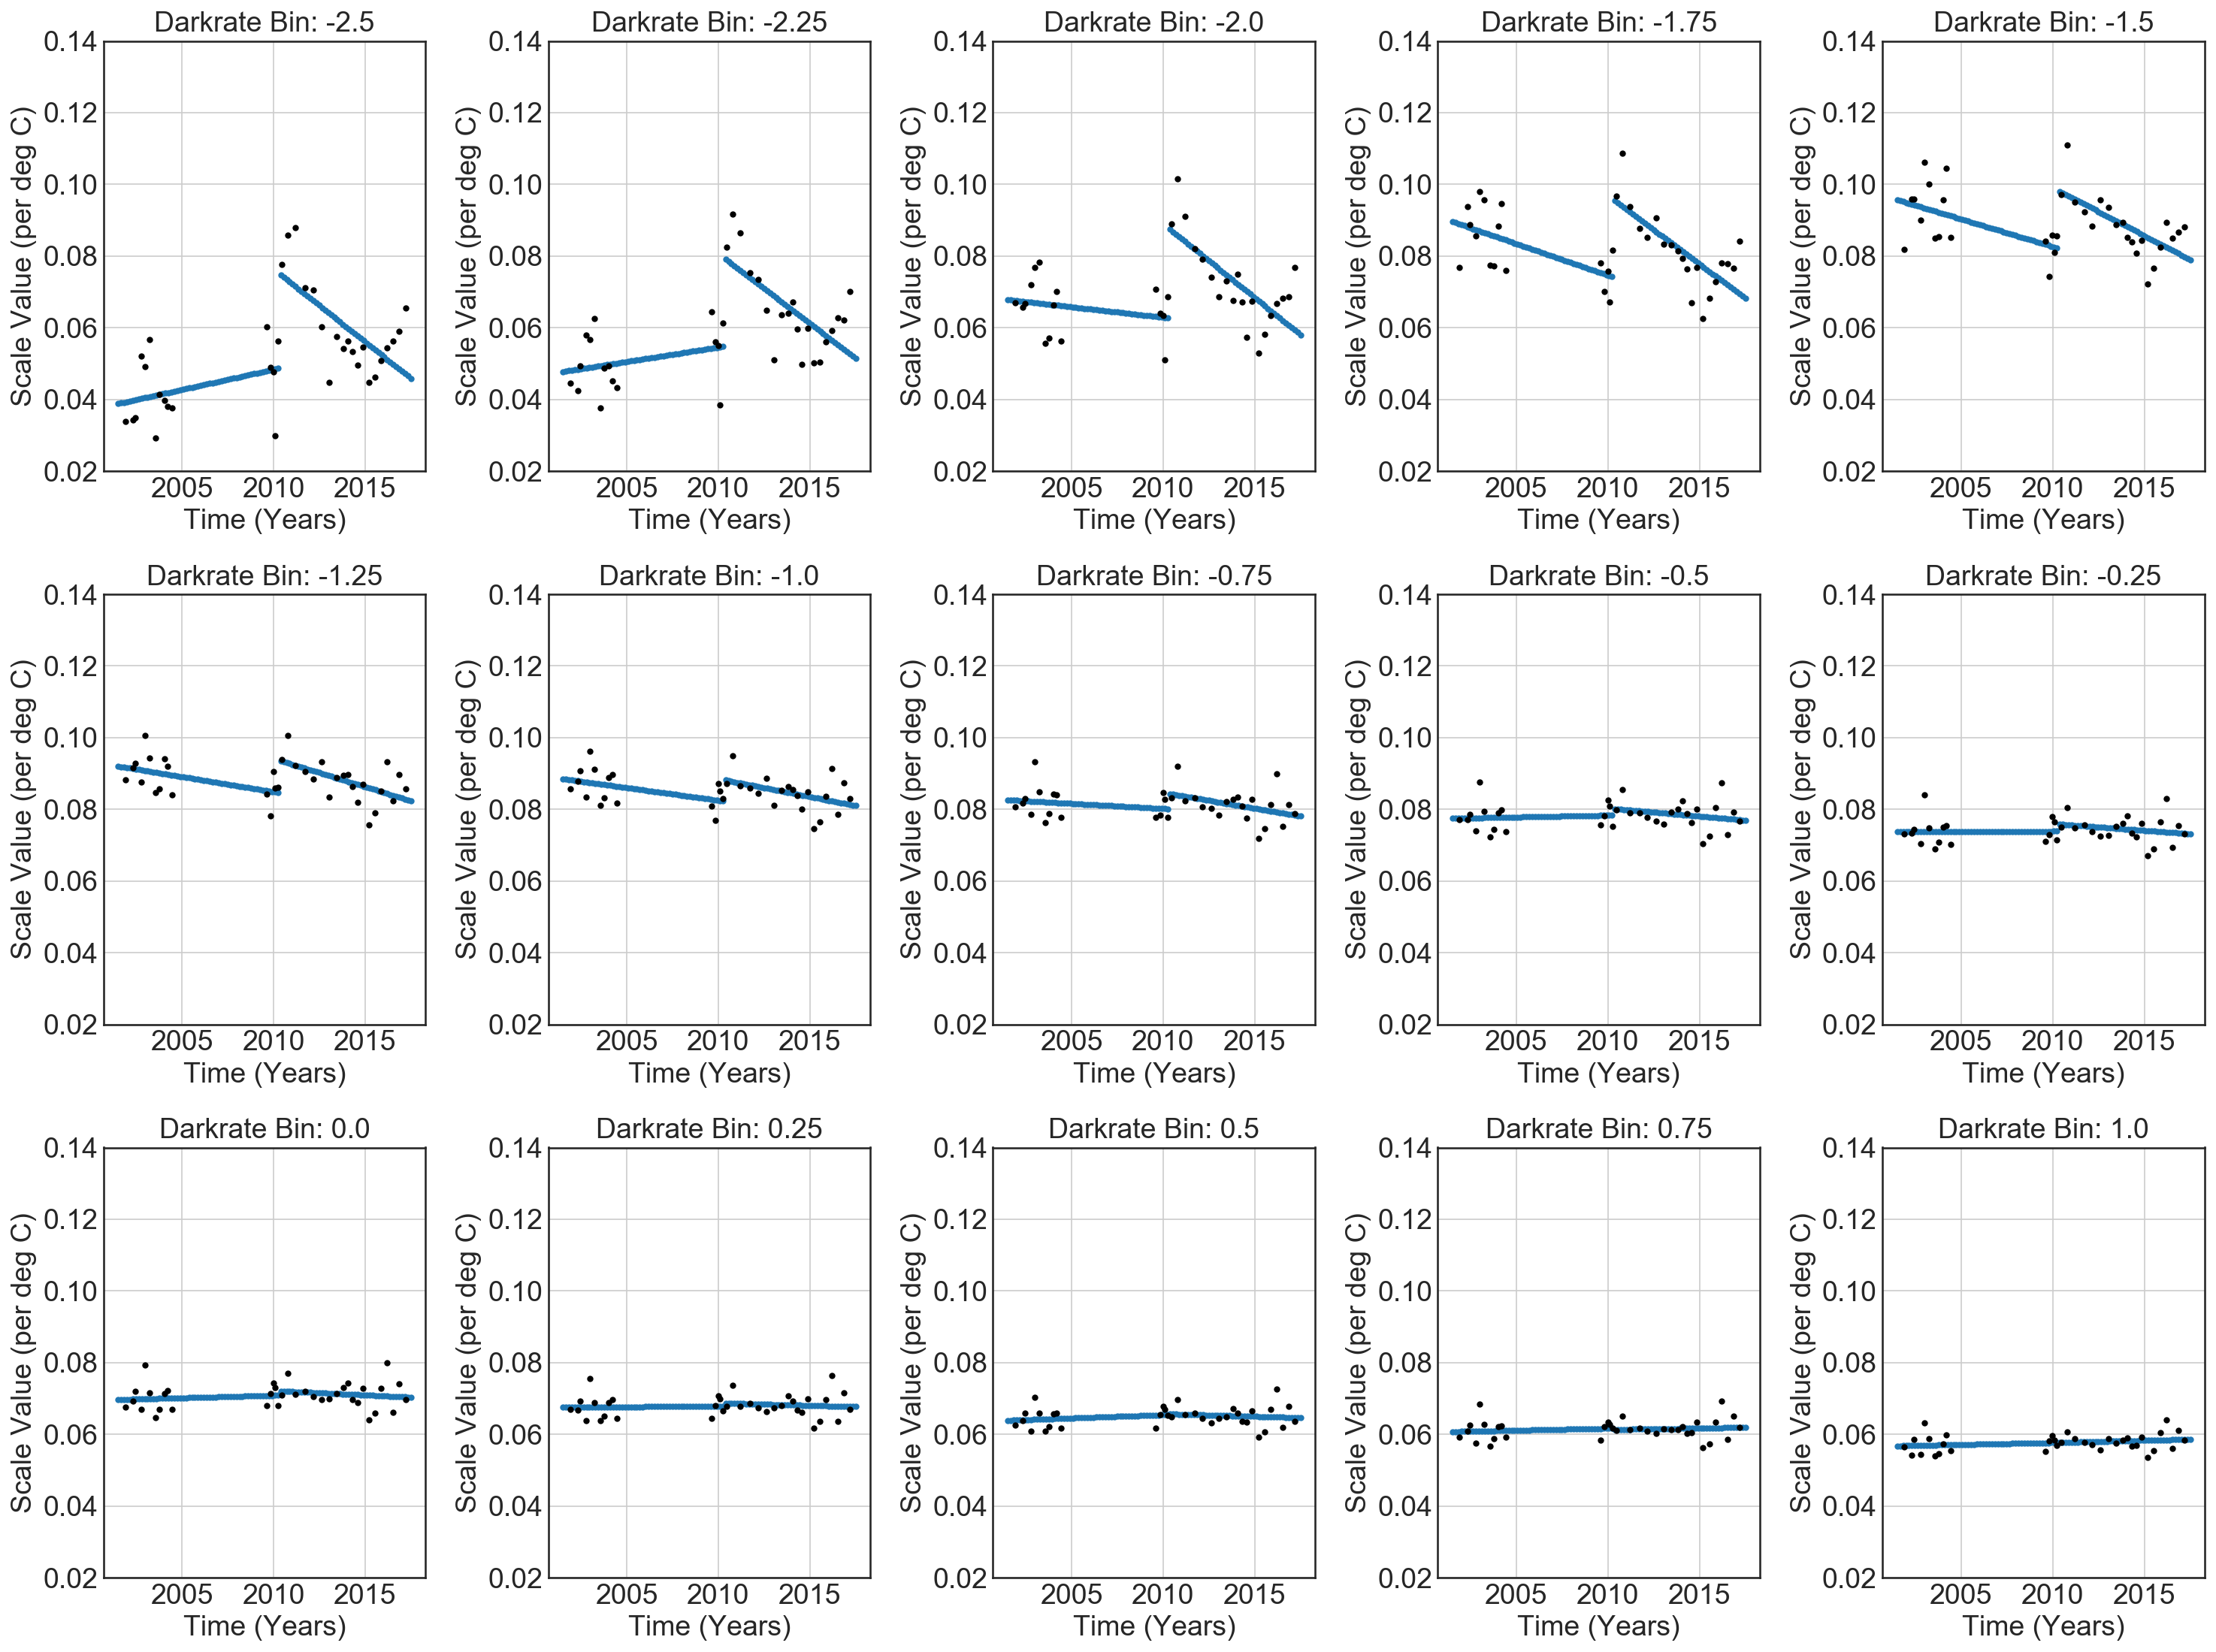

In [8]:
#Time dependence

data = scalevalues[13]
dt_arr = np.array(dt_stamps)
n=1

fitspace = np.linspace(2001.5,2017.5,100)
#fit, C_p =  np.polyfit(dt_stamps,data,n,cov=True)
#p = np.poly1d(fit)

#Piecewise

def piecewise(x,*param):
    pre_slope,post_slope,pre_int,post_int = param
    return np.piecewise(x, 
                        [x < 2010.3,x>2010.3], 
                        [lambda x:pre_slope*x+pre_int, 
                         lambda x:post_slope*x+post_int])

fig = plt.figure(figsize=(20,15))
fig.dpi = 150
for idx,data in enumerate(scalevalues):

    p0=[-0.01,1,-0.01,1]
    coeff, var_matrix = curve_fit(piecewise,dt_arr,data,p0=p0)
    piecefit = piecewise(fitspace, *coeff)
    ax = fig.add_subplot(3,5,idx+1)
    ax.set_title("Darkrate Bin: {}".format(darkrate_bins[idx]),fontsize=18)
    ax.set_ylabel("Scale Value (per deg C)",fontsize=18)
    ax.set_xlabel("Time (Years)",fontsize=18)
    ax.set_ylim(0.02,0.14)
    ax.grid()
    ax.plot(fitspace,piecefit,'.')
    ax.plot(dt_arr,data,".", label = "data",color='k')
plt.tight_layout()

## Time Dependent Skewed Norm Parameters

In [9]:
#Bring it all together

darkrate_bins
dt_arr

"""
loc_params = [  4.51517886e-02,  -9.24618685e+01,   1.87346115e-02,  -3.97023609e+01]
scale_params=[  6.62731813e-01,  -1.31594532e+03,  -1.23706077e+00,   2.49979569e+03,
  -1.15648580e+00,   2.34668104e+03]
shape_params=[  4.89898646e+00,  -9.76813906e+03,   1.87486509e+01,  -3.76486770e+04,
  -7.48202361e+00,   1.51243715e+04]
lin_params=[0.01,0.01]
params = loc_params+scale_params+shape_params+lin_params
"""
loc_params = [  4.51517886e-02,  -9.24618685e+01,   1.87346115e-02,  -3.97023609e+01]
scale_params = [  2.70463899e-01,  -5.30172034e+02,  -1.15648720e+00,   2.34668386e+03]
shape_params = [ -1.28084919e+00,   2.61089138e+03,  -7.48202708e+00,   1.51243785e+04]
lin_params=[0.01,0.01]
params = loc_params+scale_params+shape_params+lin_params

def sv_model(params, darkrate_bins, dt_arr, scalevalues):
    #loc_slope1,loc_int1,loc_slope2,loc_int2,scale_slope1,scale_int1,scale_slope2,scale_int2, scale_slope3,scale_int3,shape_slope1,shape_int1,shape_slope2,shape_int2, shape_slope3,shape_int3,c,d=params #darkrate dependence and time dep parameters
    loc_slope1,loc_int1,loc_slope2,loc_int2,scale_slope1,scale_int1,scale_slope2,scale_int2,shape_slope1,shape_int1,shape_slope2,shape_int2,c,d=params #darkrate dependence and time dep parameter
    darkrate_bins = np.array([darkrate_bins for _ in range(len(dt_arr))]).T
    dt_arr = np.array([dt_arr for _ in range(len(darkrate_bins))])
    
    #Time dependent parameters
    loc = np.piecewise(dt_arr, 
                           [(dt_arr < 2010.3),(dt_arr>2010.3)], 
                           [lambda dt_arr:loc_slope1*dt_arr+loc_int1, 
                            lambda dt_arr: loc_slope2*dt_arr+loc_int2])
    scale = np.piecewise(dt_arr, 
                           [(dt_arr <= 2010.3),(dt_arr>2010.3)], 
                           [lambda dt_arr:scale_slope1*dt_arr+scale_int1, 
                            lambda dt_arr:scale_slope2*dt_arr+scale_int2,
                            lambda dt_arr: scale_slope3*dt_arr+scale_int3])
    shape = np.piecewise(dt_arr, 
                           [(dt_arr <= 2010.3),(dt_arr>2010.3)], 
                           [lambda dt_arr:shape_slope1*dt_arr+shape_int1, 
                            lambda dt_arr:shape_slope2*dt_arr+shape_int2,
                            lambda dt_arr: shape_slope3*dt_arr+shape_int3])
    
    #Rate dependent factor
    t = (darkrate_bins-loc) / scale
    ratedep = 2 / scale * stats.norm.pdf(t) * stats.norm.cdf(shape*t) + c*darkrate_bins + d

    
    sv_modelled = ratedep
    diffs = sv_modelled - scalevalues
    return diffs.flatten()
    
result = leastsq(sv_model, params, args = (darkrate_bins, dt_arr, scalevalues,),maxfev=100000)
result_params = result[0]
result_params
loc_slope1,loc_int1,loc_slope2,loc_int2,scale_slope1,scale_int1,scale_slope2,scale_int2,shape_slope1,shape_int1,shape_slope2,shape_int2,c,d=params #darkrate dependence and time dep parameters
print(type(result_params))
with open("sv_params.csv",'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=' ',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    writer.writerow(result_params)

<class 'numpy.ndarray'>


In [10]:

test_rate=-0.01
def compute_sv(params, darkrate, year):
    loc_slope1,loc_int1,loc_slope2,loc_int2,scale_slope1,scale_int1,scale_slope2,scale_int2,shape_slope1,shape_int1,shape_slope2,shape_int2,c,d=params #darkrate dependence and time dep parameters
    dt_arr = year
    #Time dependent parameters
    loc = np.piecewise(dt_arr, 
                           [(dt_arr < 2010.3),(dt_arr>2010.3)], 
                           [lambda dt_arr:loc_slope1*dt_arr+loc_int1, 
                            lambda dt_arr: loc_slope2*dt_arr+loc_int2])
    scale = np.piecewise(dt_arr, 
                           [(dt_arr <= 2010.3),(dt_arr>2010.3)], 
                           [lambda dt_arr:scale_slope1*dt_arr+scale_int1, 
                            lambda dt_arr:scale_slope2*dt_arr+scale_int2])
    shape = np.piecewise(dt_arr, 
                           [(dt_arr <= 2010.3),(dt_arr>2010.3)], 
                           [lambda dt_arr:shape_slope1*dt_arr+shape_int1, 
                            lambda dt_arr:shape_slope2*dt_arr+shape_int2])
    #Rate dependent factor
    t = (darkrate-loc) / scale
    ratedep = 2 / scale * stats.norm.pdf(t) * stats.norm.cdf(shape*t) + c*darkrate + d
    

    computed_sv = ratedep
    return computed_sv

compute_sv(result_params, 4, 2015.32)


0.010572463006649657

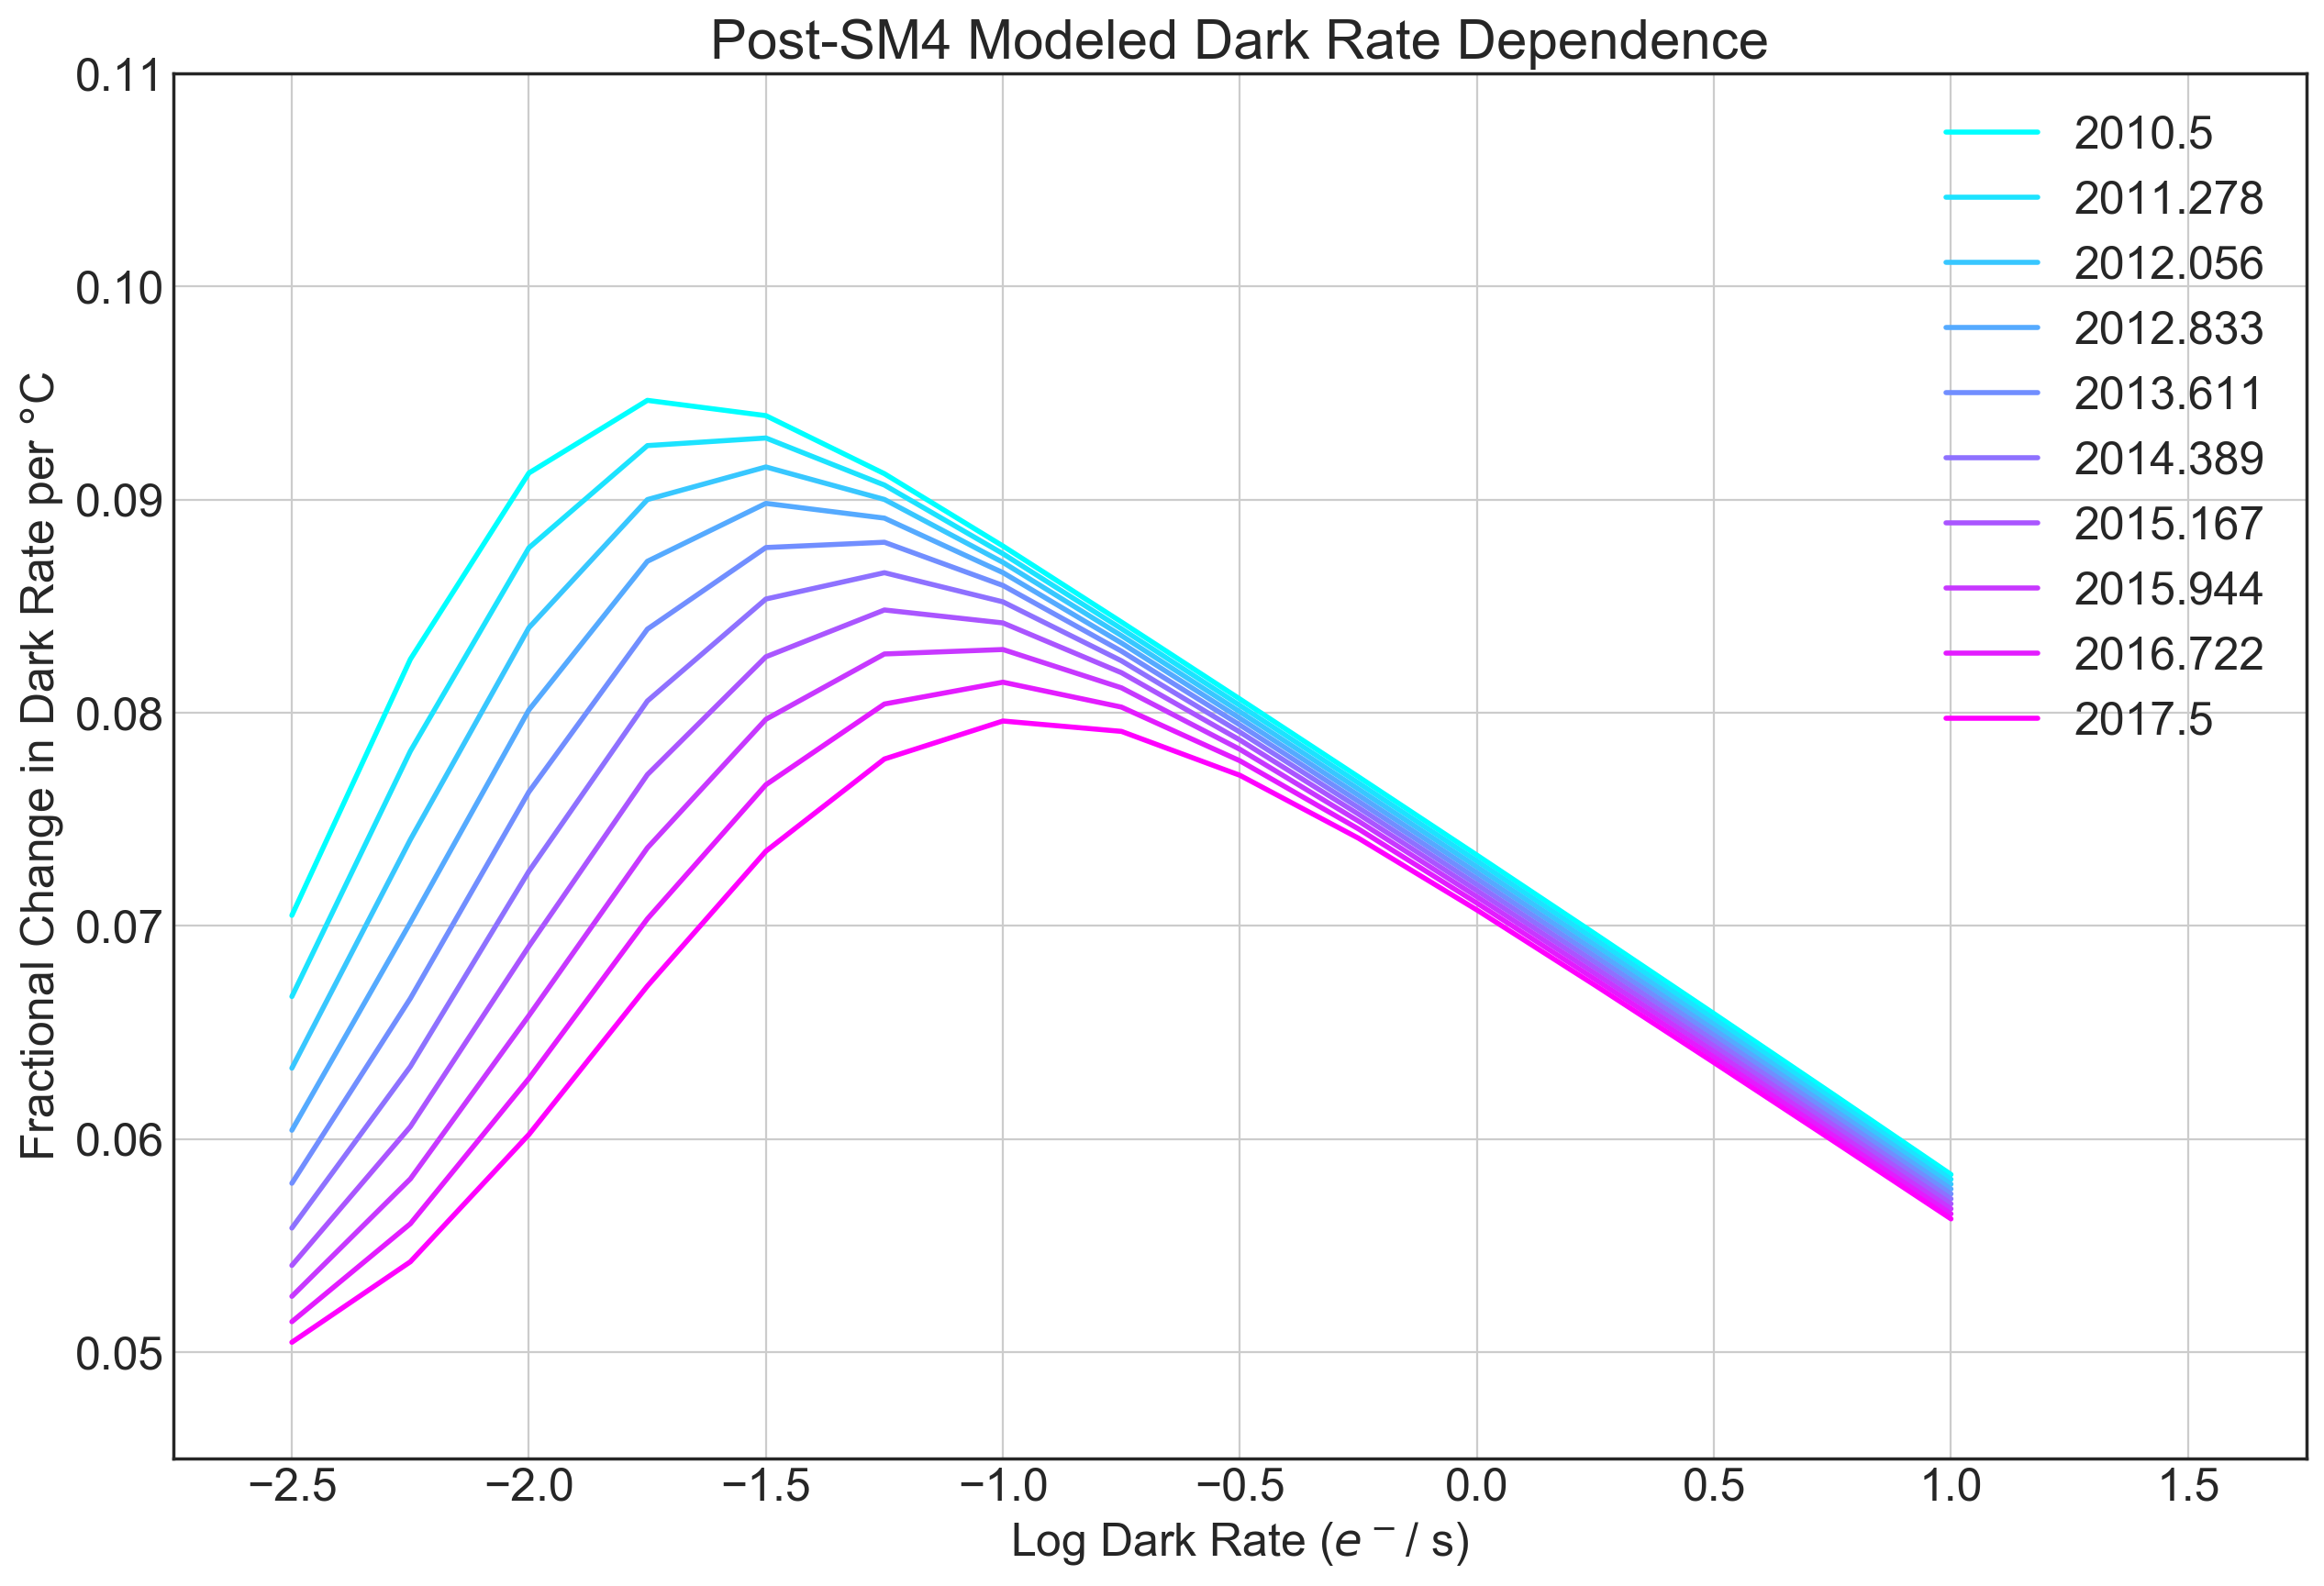

In [11]:
fig = plt.figure(figsize=(15,10))
fig.dpi = 200
plt.grid()
plt.title("Post-SM4 Modeled Dark Rate Dependence")
plt.xlim(-2.75,1.75)
plt.ylim(0.045,0.11)
for idx,year in enumerate(np.linspace(2010.5,2017.5,10)):
    color_idx = np.linspace(0, 1, 10)
    model_darkrate_dep = []
    for darkrate in darkrate_bins:
        computed_sv = compute_sv(result_params, darkrate, year)
        model_darkrate_dep.append(computed_sv)
    plt.plot(darkrate_bins,model_darkrate_dep,color = plt.cm.cool(color_idx[idx]),label = str(np.round(year,3)),lw=2)
plt.legend()
#plt.tight_layout()
plt.xlabel(r"Log Dark Rate ($e^-$/ s)")
plt.ylabel(r"Fractional Change in Dark Rate per $\degree$C")
plt.savefig("postSM4_model.png")

## Model vs Data

In [12]:
model_sv_matrix = [[compute_sv(result_params,darkrate,time) for darkrate in darkrate_bins] for time in dt_stamps]
dt_stamps

[2001.8964611872145,
 2002.3100456621005,
 2002.434703196347,
 2002.7716894977168,
 2002.9800228310503,
 2003.2293378995435,
 2003.5607305936073,
 2003.7716894977168,
 2004.0224885844748,
 2004.189611872146,
 2004.4374429223744,
 2009.6086757990868,
 2009.8182648401826,
 2009.985502283105,
 2010.0704337899542,
 2010.2319634703197,
 2010.4401826484018,
 2010.7771689497717,
 2011.1937214611871,
 2011.734703196347,
 2012.1526255707763,
 2012.6114155251141,
 2013.030707762557,
 2013.4429223744291,
 2013.8210045662101,
 2014.0731735159818,
 2014.3182648401826,
 2014.5689497716894,
 2014.862100456621,
 2015.1964611872147,
 2015.5278538812786,
 2015.862100456621,
 2016.1978310502284,
 2016.530593607306,
 2016.8648401826483,
 2017.199200913242]

/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/matplotlib/figure.py:1743: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


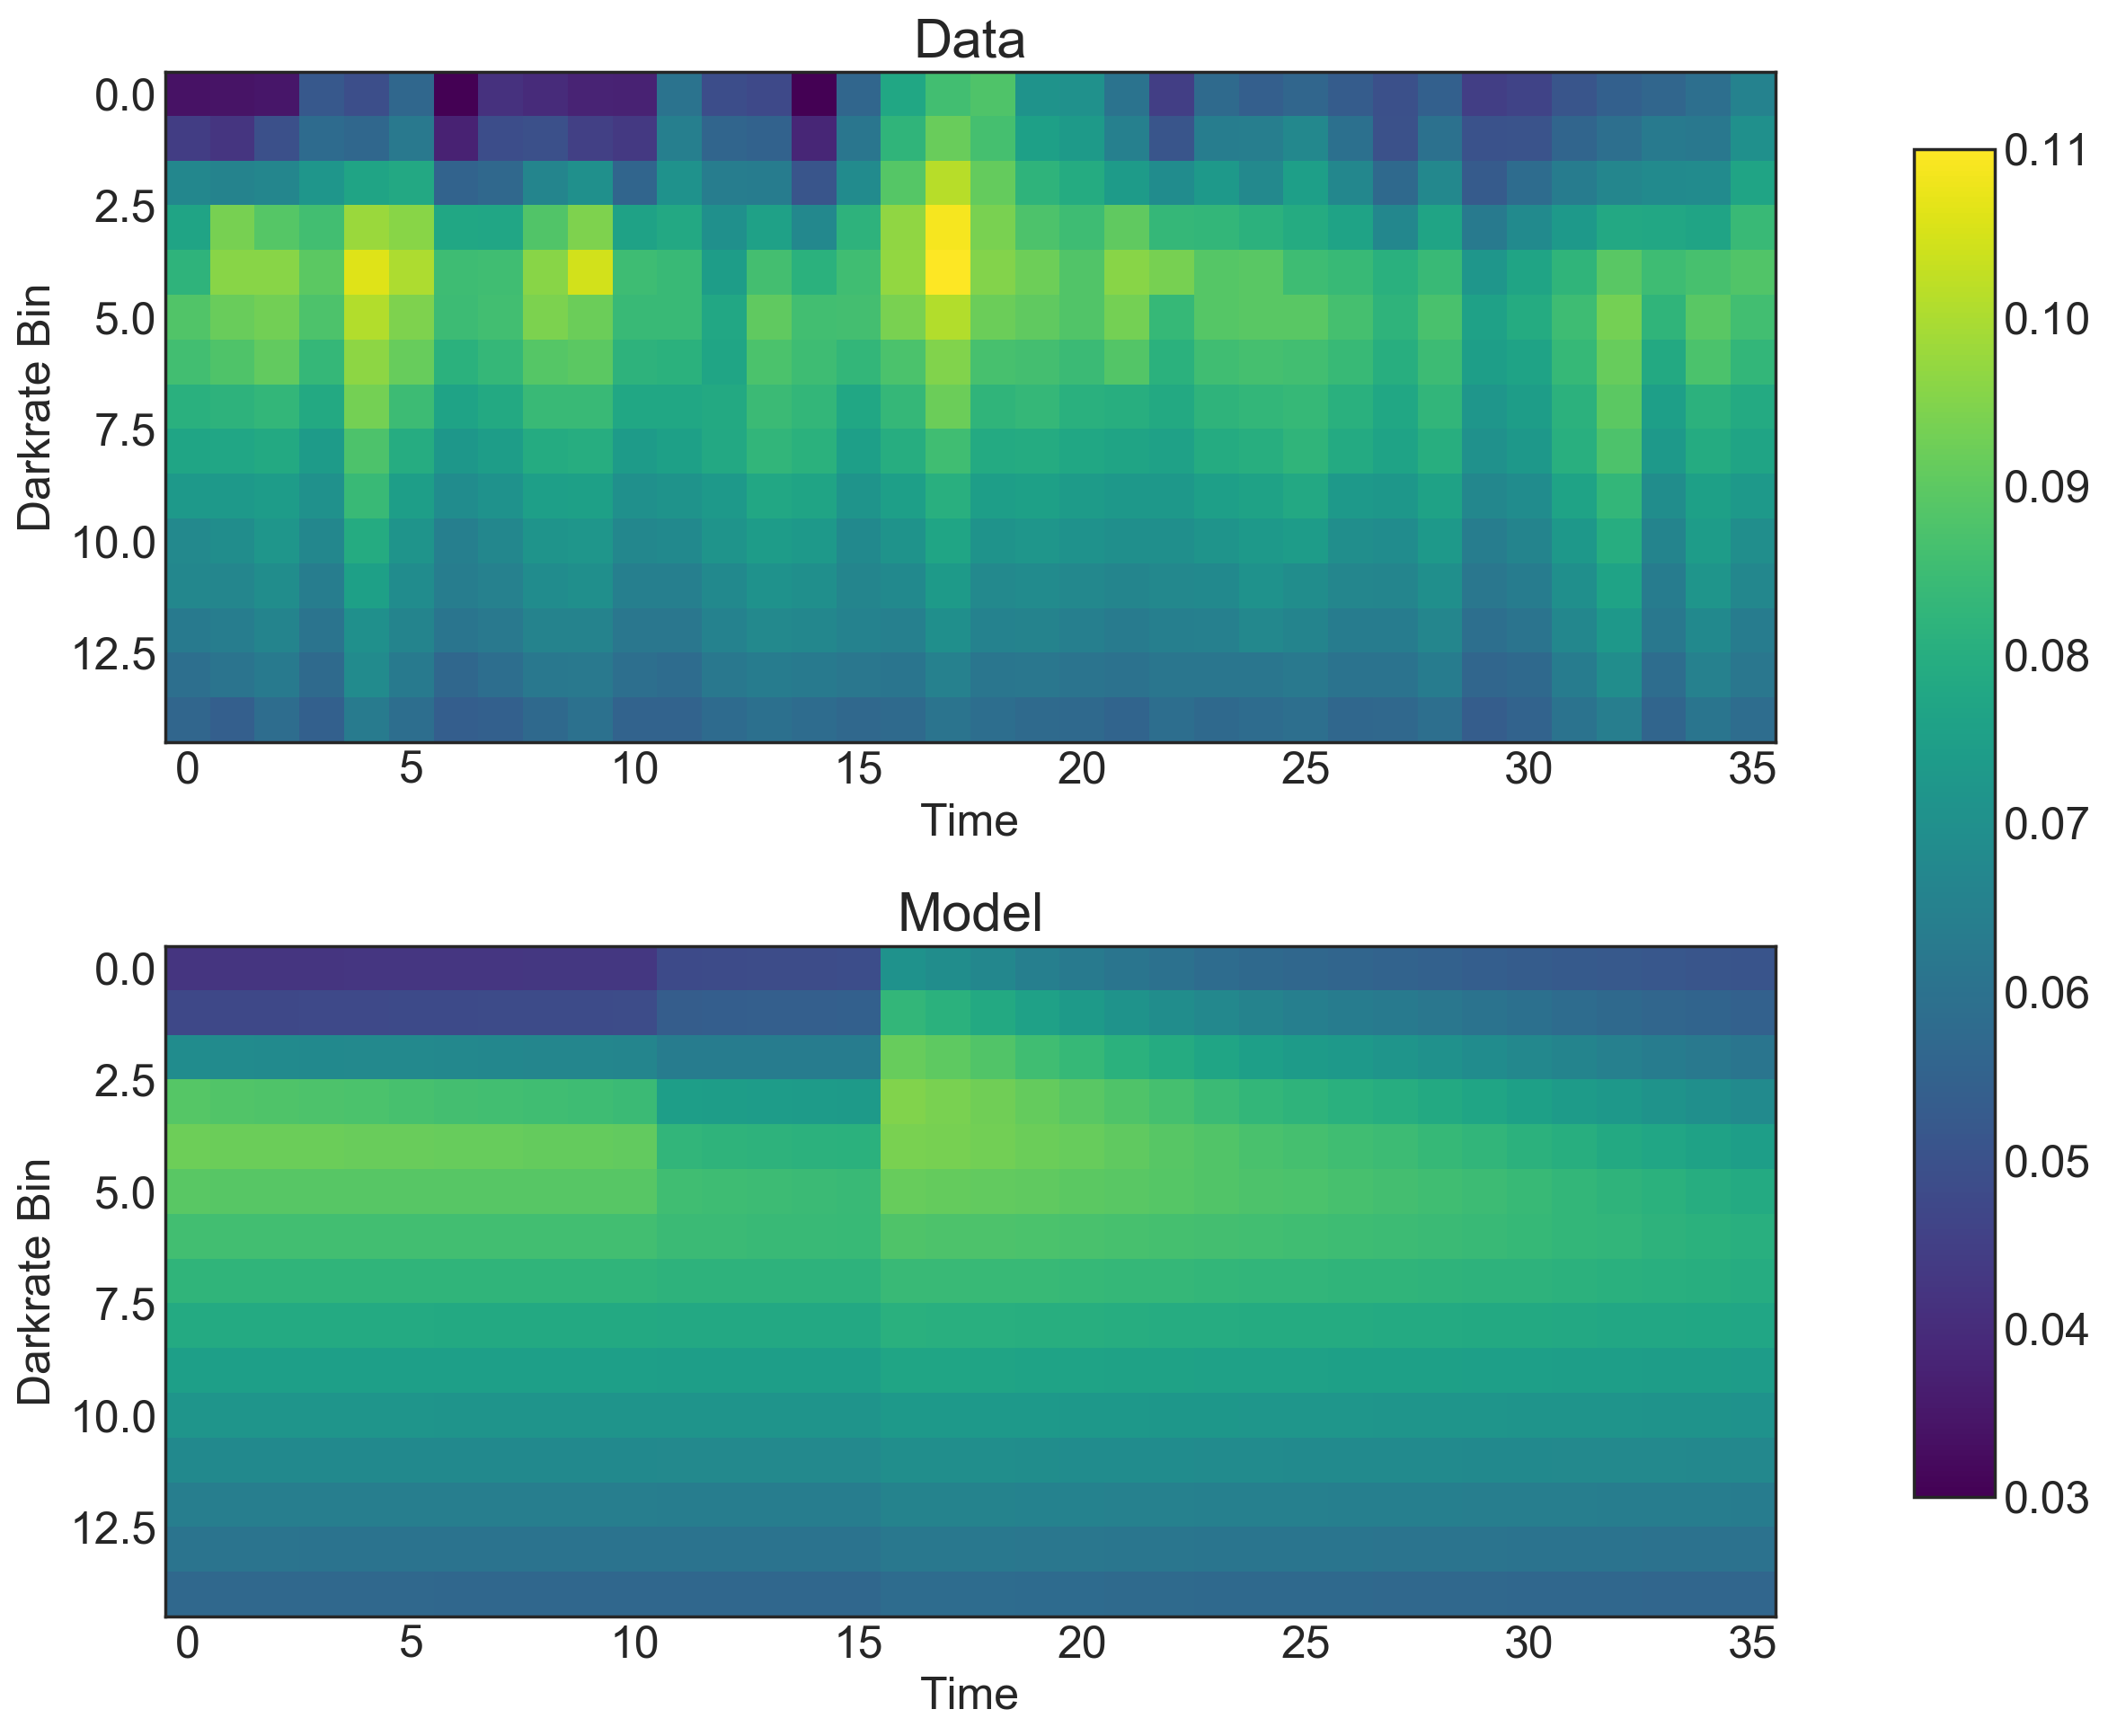

In [13]:
model_sv_matrix = [[compute_sv(result_params,darkrate,time) for darkrate in darkrate_bins] for time in dt_stamps]

fig,(ax1,ax2) = plt.subplots(2,1,figsize=(15,10))

im1 = ax1.imshow(scalevalues,cmap='viridis',interpolation='nearest',vmin=0.03,vmax=0.11)
ax1.set_title("Data")
ax1.set_xlabel("Time")
ax1.set_ylabel("Darkrate Bin")
#ax1.set_xticks(np.linspace(0,len(dt_stamps)-1))
#ax1.set_xticklabels(dt_stamps,rotation = 90,fontsize=12)
im2 = ax2.imshow(np.array(model_sv_matrix).T, cmap='viridis',interpolation='nearest',vmin=0.03,vmax=0.11)
ax2.set_title("Model")
ax2.set_xlabel("Time")
ax2.set_ylabel("Darkrate Bin")
#ax2.set_xticks(np.linspace(0,len(dt_stamps)-1))
#ax2.set_xticklabels(dt_stamps,rotation = 90,fontsize=12)


fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.03, 0.75])
fig.colorbar(im2, cax=cbar_ax)
fig.dpi = 200


plt.tight_layout()

### Residuals

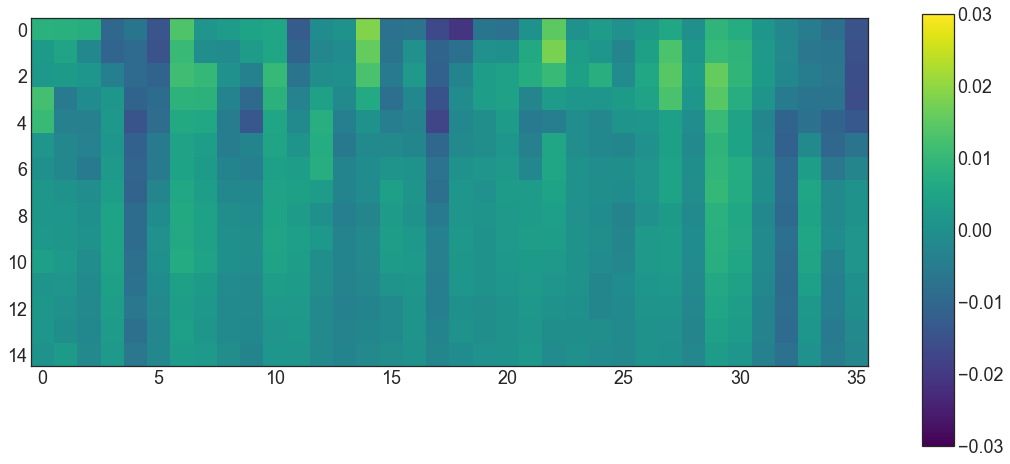

In [14]:
fig,ax = plt.subplots(figsize=(15,10))

im = ax.imshow(np.array(model_sv_matrix).T-scalevalues, cmap='viridis',vmin=-0.03,vmax=0.03)
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)
#ax.set_xticklabels(dt_stamps, rotation=90)
#ax.set_yticks(darkrate_bins)

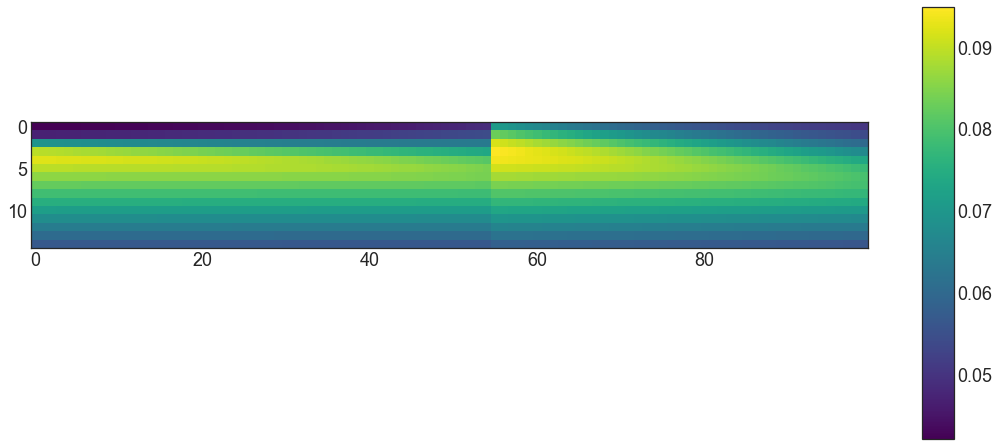

In [15]:
timespace = np.linspace(2001.5,2017.5,100)
model_sv_matrix = [[compute_sv(result_params,darkrate,time) for darkrate in darkrate_bins] for time in timespace]

fig,ax = plt.subplots(figsize=(15,10))

im = ax.imshow(np.array(model_sv_matrix).T, cmap='viridis')
cbar_ax = fig.add_axes([0.95, 0.15, 0.03, 0.6])
fig.colorbar(im, cax=cbar_ax)

## Applying a Correction

In [70]:
#dark = fits.open("/Users/dbranton/STIS/pixelhistory/corrtest/reffiles/sourcefiles/obn25avsq_flt.fits")
#dark = fits.open("/Users/dbranton/STIS/refstis/refstis/testdata/2011data/backup_flts/obn315gwq_flt.fits")
#dark = fits.open("/Users/dbranton/STIS/refstis/refstis/testdata/2011data/backup_flts/obn31lmvq_flt.fits")
#dark = fits.open("/Users/dbranton/STIS/refstis/refstis/testdata/2015data/backup_flts/ocqq9ynpq_flt.fits")
dark = fits.open("/Users/dbranton/STIS/refstis/refstis/testdata/2015data/backup_flts/ocqq9tq6q_flt.fits")
print(dark[1].header['OCCDHTAV'])
print(dark[0].header['TDATEOBS'])
reffile = dark[0].header['DARKFILE'].split('$')[-1]
print(reffile)
reffile = '/grp/hst/cdbs/oref/'+reffile
weekdark_files = str(fits.open(reffile)[0].header['HISTORY']).split("The following input files were used:")[-1].split("_flt.fits")
weekdark_string = ''
for dark_file in weekdark_files[:-1]:
    weekdark_string+=dark_file[1:]+' '
print(weekdark_string)
ATODGAIN = dark[0].header['ATODGAIN']
EXPTIME = dark[1].header['EXPTIME']

#fits.open(reffile)[0].header

19.0943
2015-10-25
02a19208o_drk.fits
ocqq9gauq ocqq9hb5q ocqq9igzq ocqq9jh5q ocqq9klbq ocqq9llmq ocqq9mxvq ocqq9nxiq ocqq9oerq ocqq9pegq ocqq9qkcq ocqq9rkoq ocqq9spyq ocqq9tq6q ocqq9ua1q ocqq9va8q ocqq9wigq ocqq9xinq 


1.0


/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in log10
/Users/dbranton/miniconda3/envs/astroconda/lib/python3.5/site-packages/ipykernel_launcher.py:50: RuntimeWarning: invalid value encountered in less


2629.18159919
Pipeline Median: -0.414843586672
Pipeline Standard Deviation: 9.40944081088
Tweaked Median: -0.340064539277
Tweaked Standard Deviation: 9.33073861066


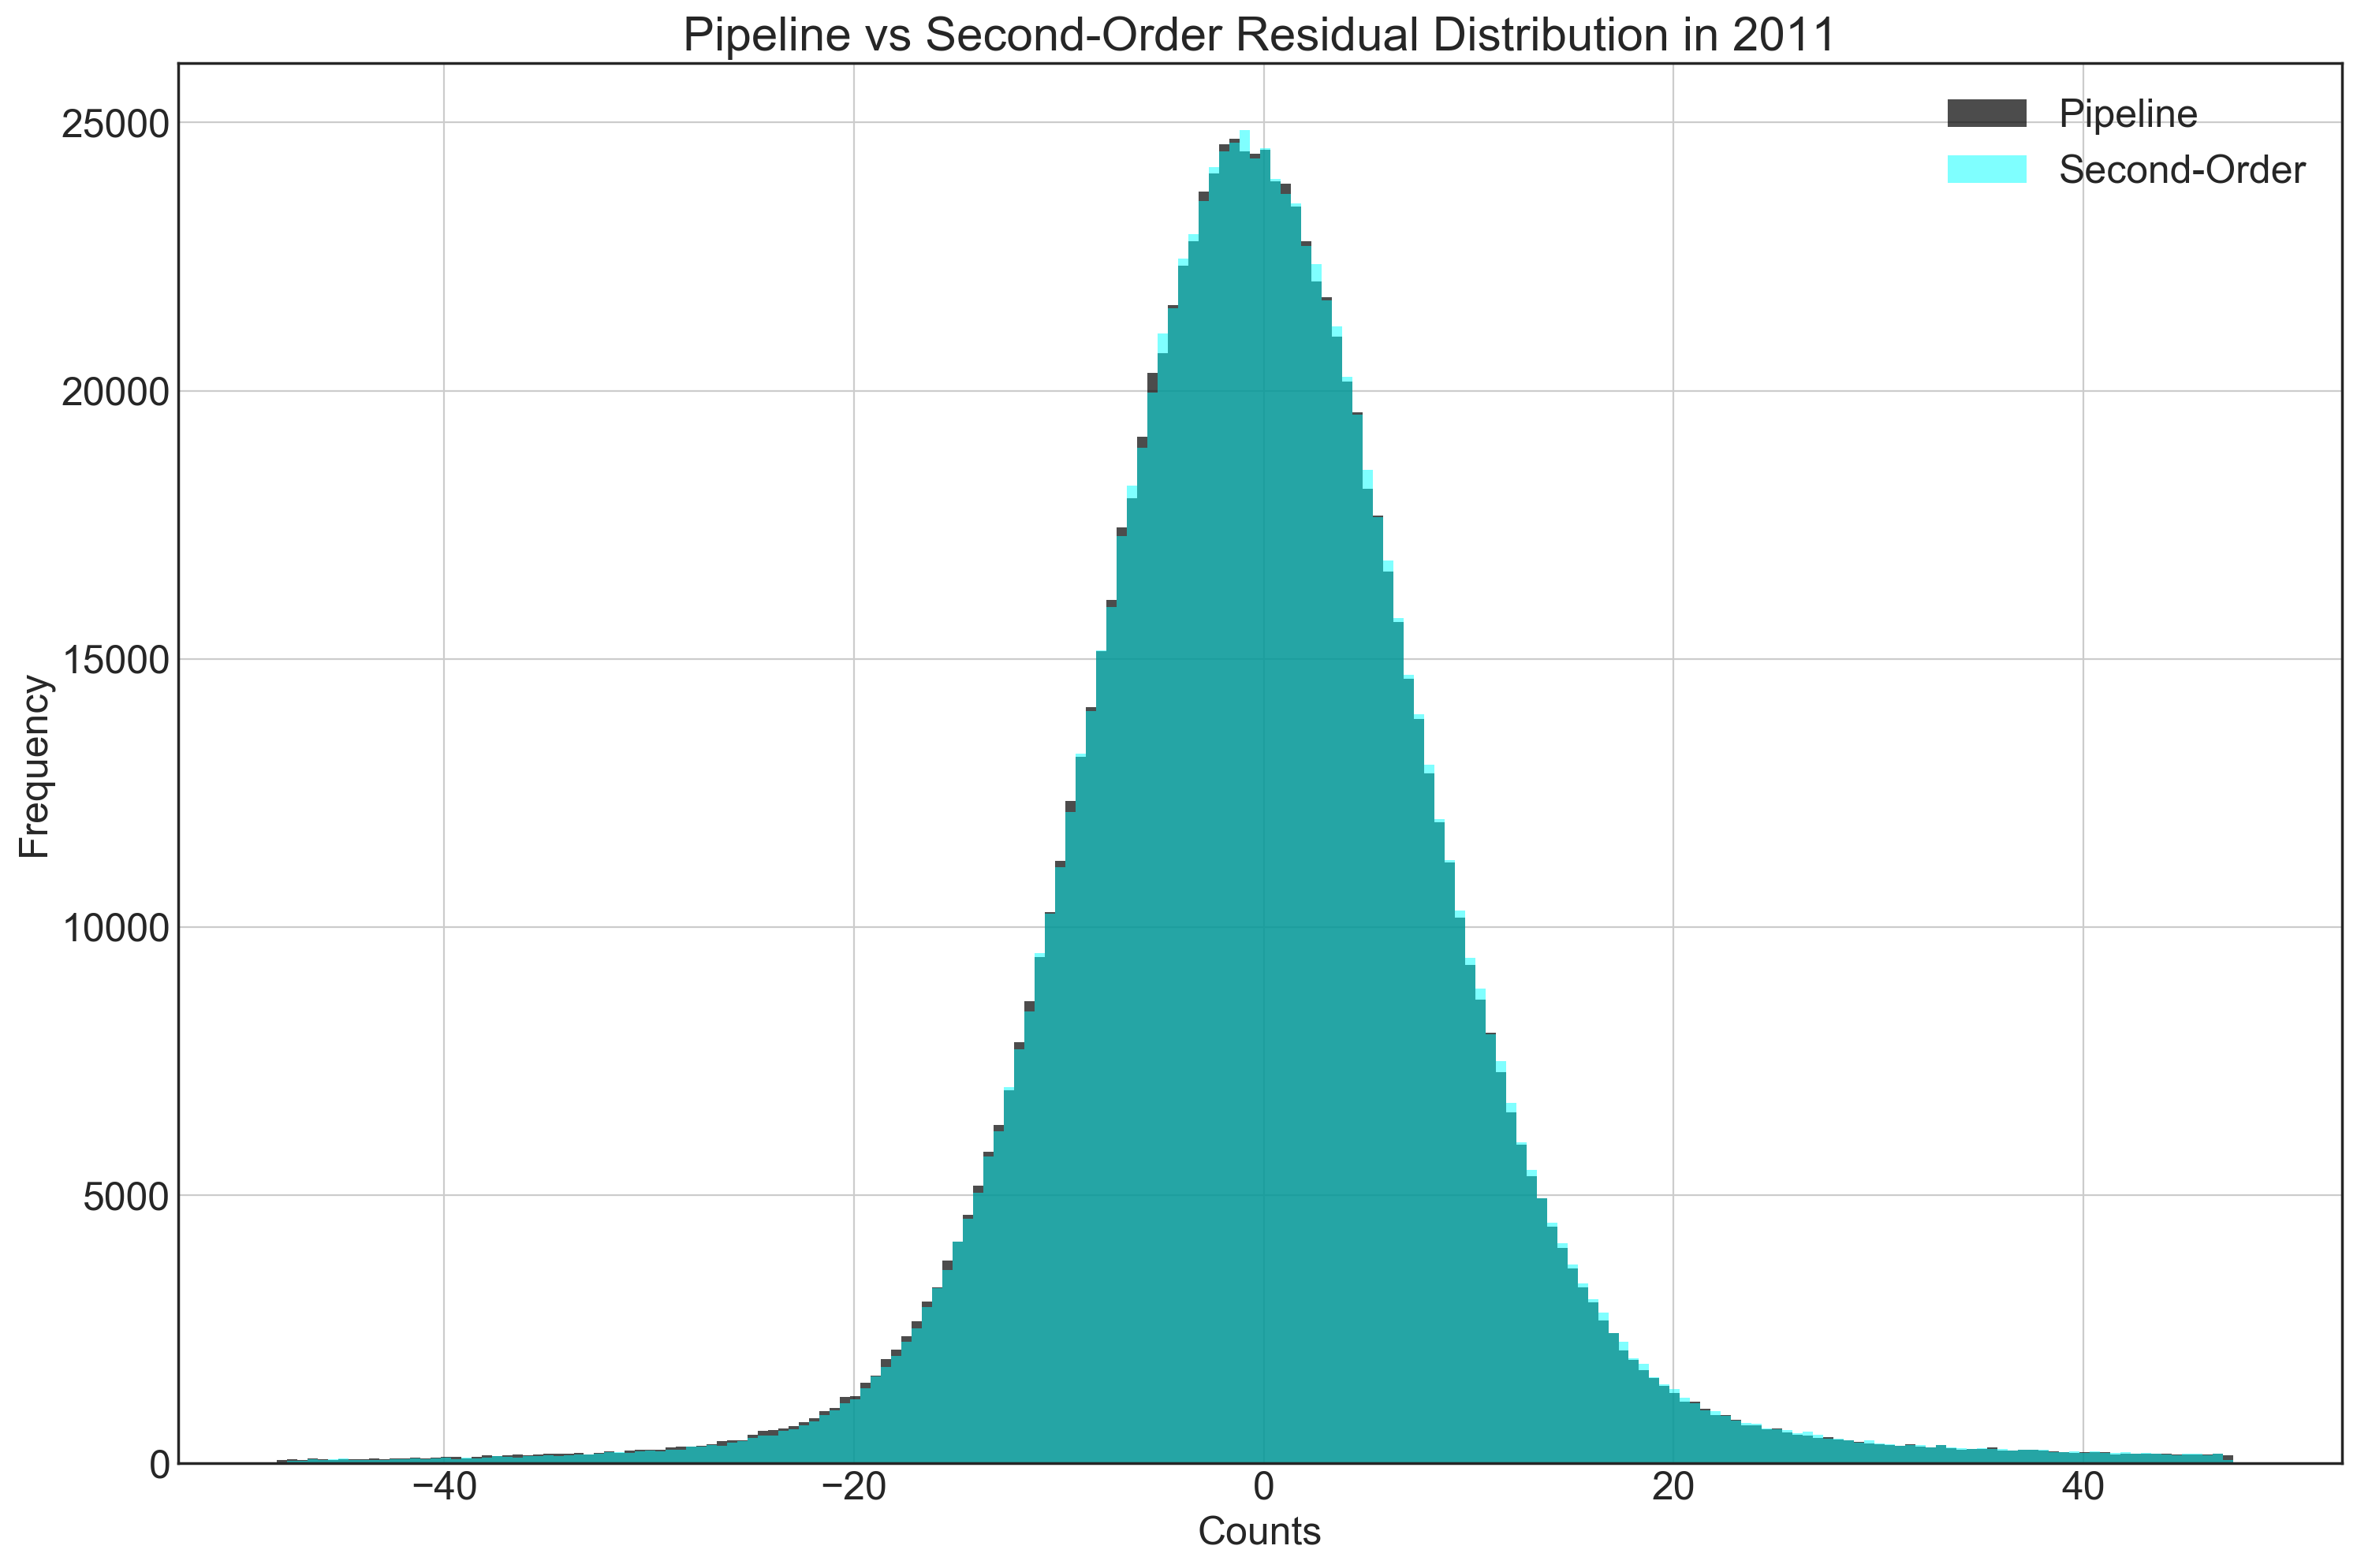

In [71]:
#Apply correction
REF_TEMP = 18.0
ATODGAIN = dark[0].header['ATODGAIN']
EXPTIME = dark[1].header['EXPTIME']
OCCDHTAV = dark[1].header['OCCDHTAV']
dark_data = dark[1].data
dq_flag = (dark['DQ'].data !=16) & (dark['DQ'].data != 16384)
DRK_VS_T = 0.07
print(ATODGAIN)

orig_reffile = fits.open(reffile)
orig_refdata = orig_reffile[1].data*EXPTIME/ATODGAIN
orig_scaled = orig_refdata*(1+DRK_VS_T*(OCCDHTAV-REF_TEMP))

#tweaked_reffile = fits.open("/Users/dbranton/STIS/pixelhistory/corrtest/reffiles/v471332so_drk.fits")
#tweaked_reffile = fits.open("/Users/dbranton/STIS/refstis/refstis/testdata/2011data/weekdark_data/v7i1156po_drk_2nd.fits")
tweaked_reffile = fits.open("/Users/dbranton/STIS/refstis/refstis/testdata/2015data/ocqq9ynpq_weekdark/02a19208o_drk_stand.fits")
tweaked_refdata = tweaked_reffile[1].data


#firstorder_reffile = fits.open("/Users/dbranton/STIS/refstis/refstis/testdata/2015data/ocqq9ynpq_weekdark/02a19208o_drk_control_biased.fits")
#firstorder_refdata = firstorder_reffile[1].data*EXPTIME/ATODGAIN
#firstorder_svrefdata = firstorder_refdata
#firstorder_scaled = firstorder_refdata*(1+DRK_VS_T*(OCCDHTAV-REF_TEMP))


for params in csv.reader(open('sv_params.csv', 'r'),delimiter=' ',quoting=csv.QUOTE_NONNUMERIC):
    result_params = params
    
#Retreive decimal year, exposure length and darkrates
date = datetime.datetime(*[int(item) for item in dark[1].header['DATE-OBS'].split('-')])
startOfThisYear = datetime.datetime(year=date.year, month=1, day=1)
startOfNextYear = datetime.datetime(year=date.year+1, month=1, day=1)
yearElapsed = time.mktime(date.timetuple()) - time.mktime(startOfThisYear.timetuple())
yearDuration = time.mktime(startOfNextYear.timetuple()) - time.mktime(startOfThisYear.timetuple())
year = date.year + yearElapsed/yearDuration


#dark_svrates = np.copy(dark_data)/EXPTIME*ATODGAIN
dark_svrates = np.copy(tweaked_refdata)
#dark_svrates = dark_svrates / (1 + (0.07)*(float(OCCDHTAV)-REF_TEMP))
dark_svrates[dark_svrates <=0] = 10**-3.0
dark_svrates[dark_svrates >=10**1.0]= 10**1.0
sv_matrix = np.array(compute_sv(result_params,np.log10(dark_svrates),year))
tweaked_refdata = tweaked_refdata*EXPTIME/ATODGAIN
tweaked_scaled = tweaked_refdata * (1+(sv_matrix)*(OCCDHTAV-REF_TEMP))


sigma=5
mask = np.log10(dark_data/EXPTIME) < 0.0

orig_darkdiff =(dark_data - orig_scaled)
tweaked_darkdiff = (dark_data - tweaked_scaled)
#firstorder_darkdiff = (dark_data - firstorder_scaled)

#value_mask = (tweaked_darkdiff > -2000)*(tweaked_darkdiff<1000)
#mask = mask * value_mask


orig_masked = orig_darkdiff[mask]
tweak_masked = tweaked_darkdiff[mask]
#firstorder_masked = firstorder_darkdiff[mask]
#print(np.where((tweaked_darkdiff > 2500)*(tweaked_darkdiff<5000)))
#print(np.shape(orig_masked))
#print(np.shape(tweak_masked))


orig_sclip = sigma_clip(orig_masked,sigma=sigma)
orig_sclip = np.ma.compressed(orig_sclip)
tweak_sclip = sigma_clip(tweak_masked,sigma=sigma)
tweak_sclip = np.ma.compressed(tweak_sclip)
#firstorder_sclip = sigma_clip(firstorder_masked,sigma=sigma)
#firstorder_sclip = np.ma.compressed(firstorder_sclip)

fig = plt.figure(figsize=(15,10))
fig.dpi=200
binwidth=0.5

plt.hist(np.ravel(orig_sclip),bins=np.arange(min(orig_sclip), max(orig_sclip) + binwidth, binwidth),alpha=0.7,label="Pipeline",color='k')
#plt.hist(np.ravel(firstorder_sclip),bins=200,alpha=0.7,label="Refstis",color='k')
plt.hist(np.ravel(tweak_sclip),bins=np.arange(min(orig_sclip), max(orig_sclip) + binwidth, binwidth),alpha=0.5,label="Second-Order",color='cyan')
#plt.title("Pipeline vs Second-Order Dark Count Distribution"+r" (> 1.0 $e^-/s$)")
plt.title("Pipeline vs Second-Order Residual Distribution in 2011")
stats_text = "Pipeline Median: {}\n".format(str(np.round(np.median(np.ravel(orig_sclip)),decimals=3)))
stats_text+= "Pipeline Standard Deviation: {}\n".format(str(np.round(np.std(np.ravel(orig_sclip)),decimals=3)))
stats_text+= "Second-Order Median: {}\n".format(str(np.round(np.median(np.ravel(tweak_sclip)),decimals=3)))
stats_text+= "Second-Order Deviation: {}\n".format(str(np.round(np.std(np.ravel(tweak_sclip)),decimals=3)))

#plt.text(-50,20000,stats_text)
print(np.max(tweaked_darkdiff-orig_darkdiff))
plt.legend()
plt.grid()
plt.tight_layout()
plt.xlabel("Counts")
plt.ylabel("Frequency")

#print(np.sum(np.ravel(orig_sclip)))
#print(np.sum(np.ravel(tweak_sclip)))
print("Pipeline Median: " + str(np.median(np.ravel(orig_sclip))))
print("Pipeline Standard Deviation: "+str(np.std(np.ravel(orig_sclip))))
print("Tweaked Median: " + str(np.median(np.ravel(tweak_sclip))))
print("Tweaked Standard Deviation: "+str(np.std(np.ravel(tweak_sclip))))

#plt.savefig("plots/correct_comp_2011_all.png")


In [72]:

n_row = 3
orig_cutout = orig_darkdiff[n_row:n_row+4]
tweak_cutout = tweaked_darkdiff[n_row:n_row+4]

#print(np.sum(np.ravel(orig_cutout)),np.sum(np.ravel(tweak_cutout)))
orig_sclip = sigma_clip(orig_cutout,sigma=5)
orig_sclip = np.ma.compressed(orig_sclip)
tweak_sclip = sigma_clip(tweak_cutout,sigma=5)
tweak_sclip = np.ma.compressed(tweak_sclip)
print("Dark Noise Counts/Second (52x0.2)")
print(np.sum(np.ravel(orig_sclip))/1100/1024*7,np.sum(np.ravel(tweak_sclip))/1100/1024*7)
print(np.sum(np.ravel(orig_sclip))/1100/1024*7*1100,np.sum(np.ravel(tweak_sclip))/1100/1024*7*1100)
#fig,(ax1,ax2) = plt.subplots(1,2,figsize=(15,10))
#ax.imshow(orig_data)
#ax1.imshow(orig_cutout,vmin=-25,vmax=25,interpolation='none')
#ax2.imshow(tweak_cutout,vmin=-25,vmax=25,interpolation='none')

Dark Noise Counts/Second (52x0.2)
-0.0154116685748 -0.0133650331813
-16.9528354323 -14.7015364994


In [46]:

hdu = fits.PrimaryHDU(tweaked_darkdiff)
hdu.writeto('2ndweird.fits')
hdu = fits.PrimaryHDU(orig_darkdiff)
hdu.writeto('1stweird.fits')

-0.546609264594 0.320624796998
0.528073197418 1.24336250768
0.4392685261 0.487658825947
-0.30934302609 0.306258402627
-0.238789204452 0.307161165815
-0.089338056674 0.297092924862
-0.0208510990985 0.274629271697
0.0511398092959 0.292152931894
0.10022142744 0.267023822478
0.453869741164 0.288407012648
0.556085985354 0.282098757944
0.660182876523 0.284403443794
-0.905777589656 0.2520441249
0.965528043036 0.276826837612
1.27094185317 0.441203234086
-0.28250455077 0.239203261785
1.27872854208 0.264156243802
-0.659984905594 0.306368247863
0.66204891357 0.509760073533
-0.380120472663 0.298946362453
-0.270063408299 0.301566884473
0.0173700540055 0.290453973875
0.163677290522 0.309041195701
0.709343753294 0.316274635493
0.726693930498 0.272426483942
0.937812436805 0.271569242337
-0.606811121998 0.302302347035
-0.525923999626 0.321750816084
0.401357160262 0.481548115379
-0.195638966154 0.301477197737
0.0789168103976 0.347571701801
0.181155563486 0.284559049865
0.478659502045 0.305661247624
-0.4

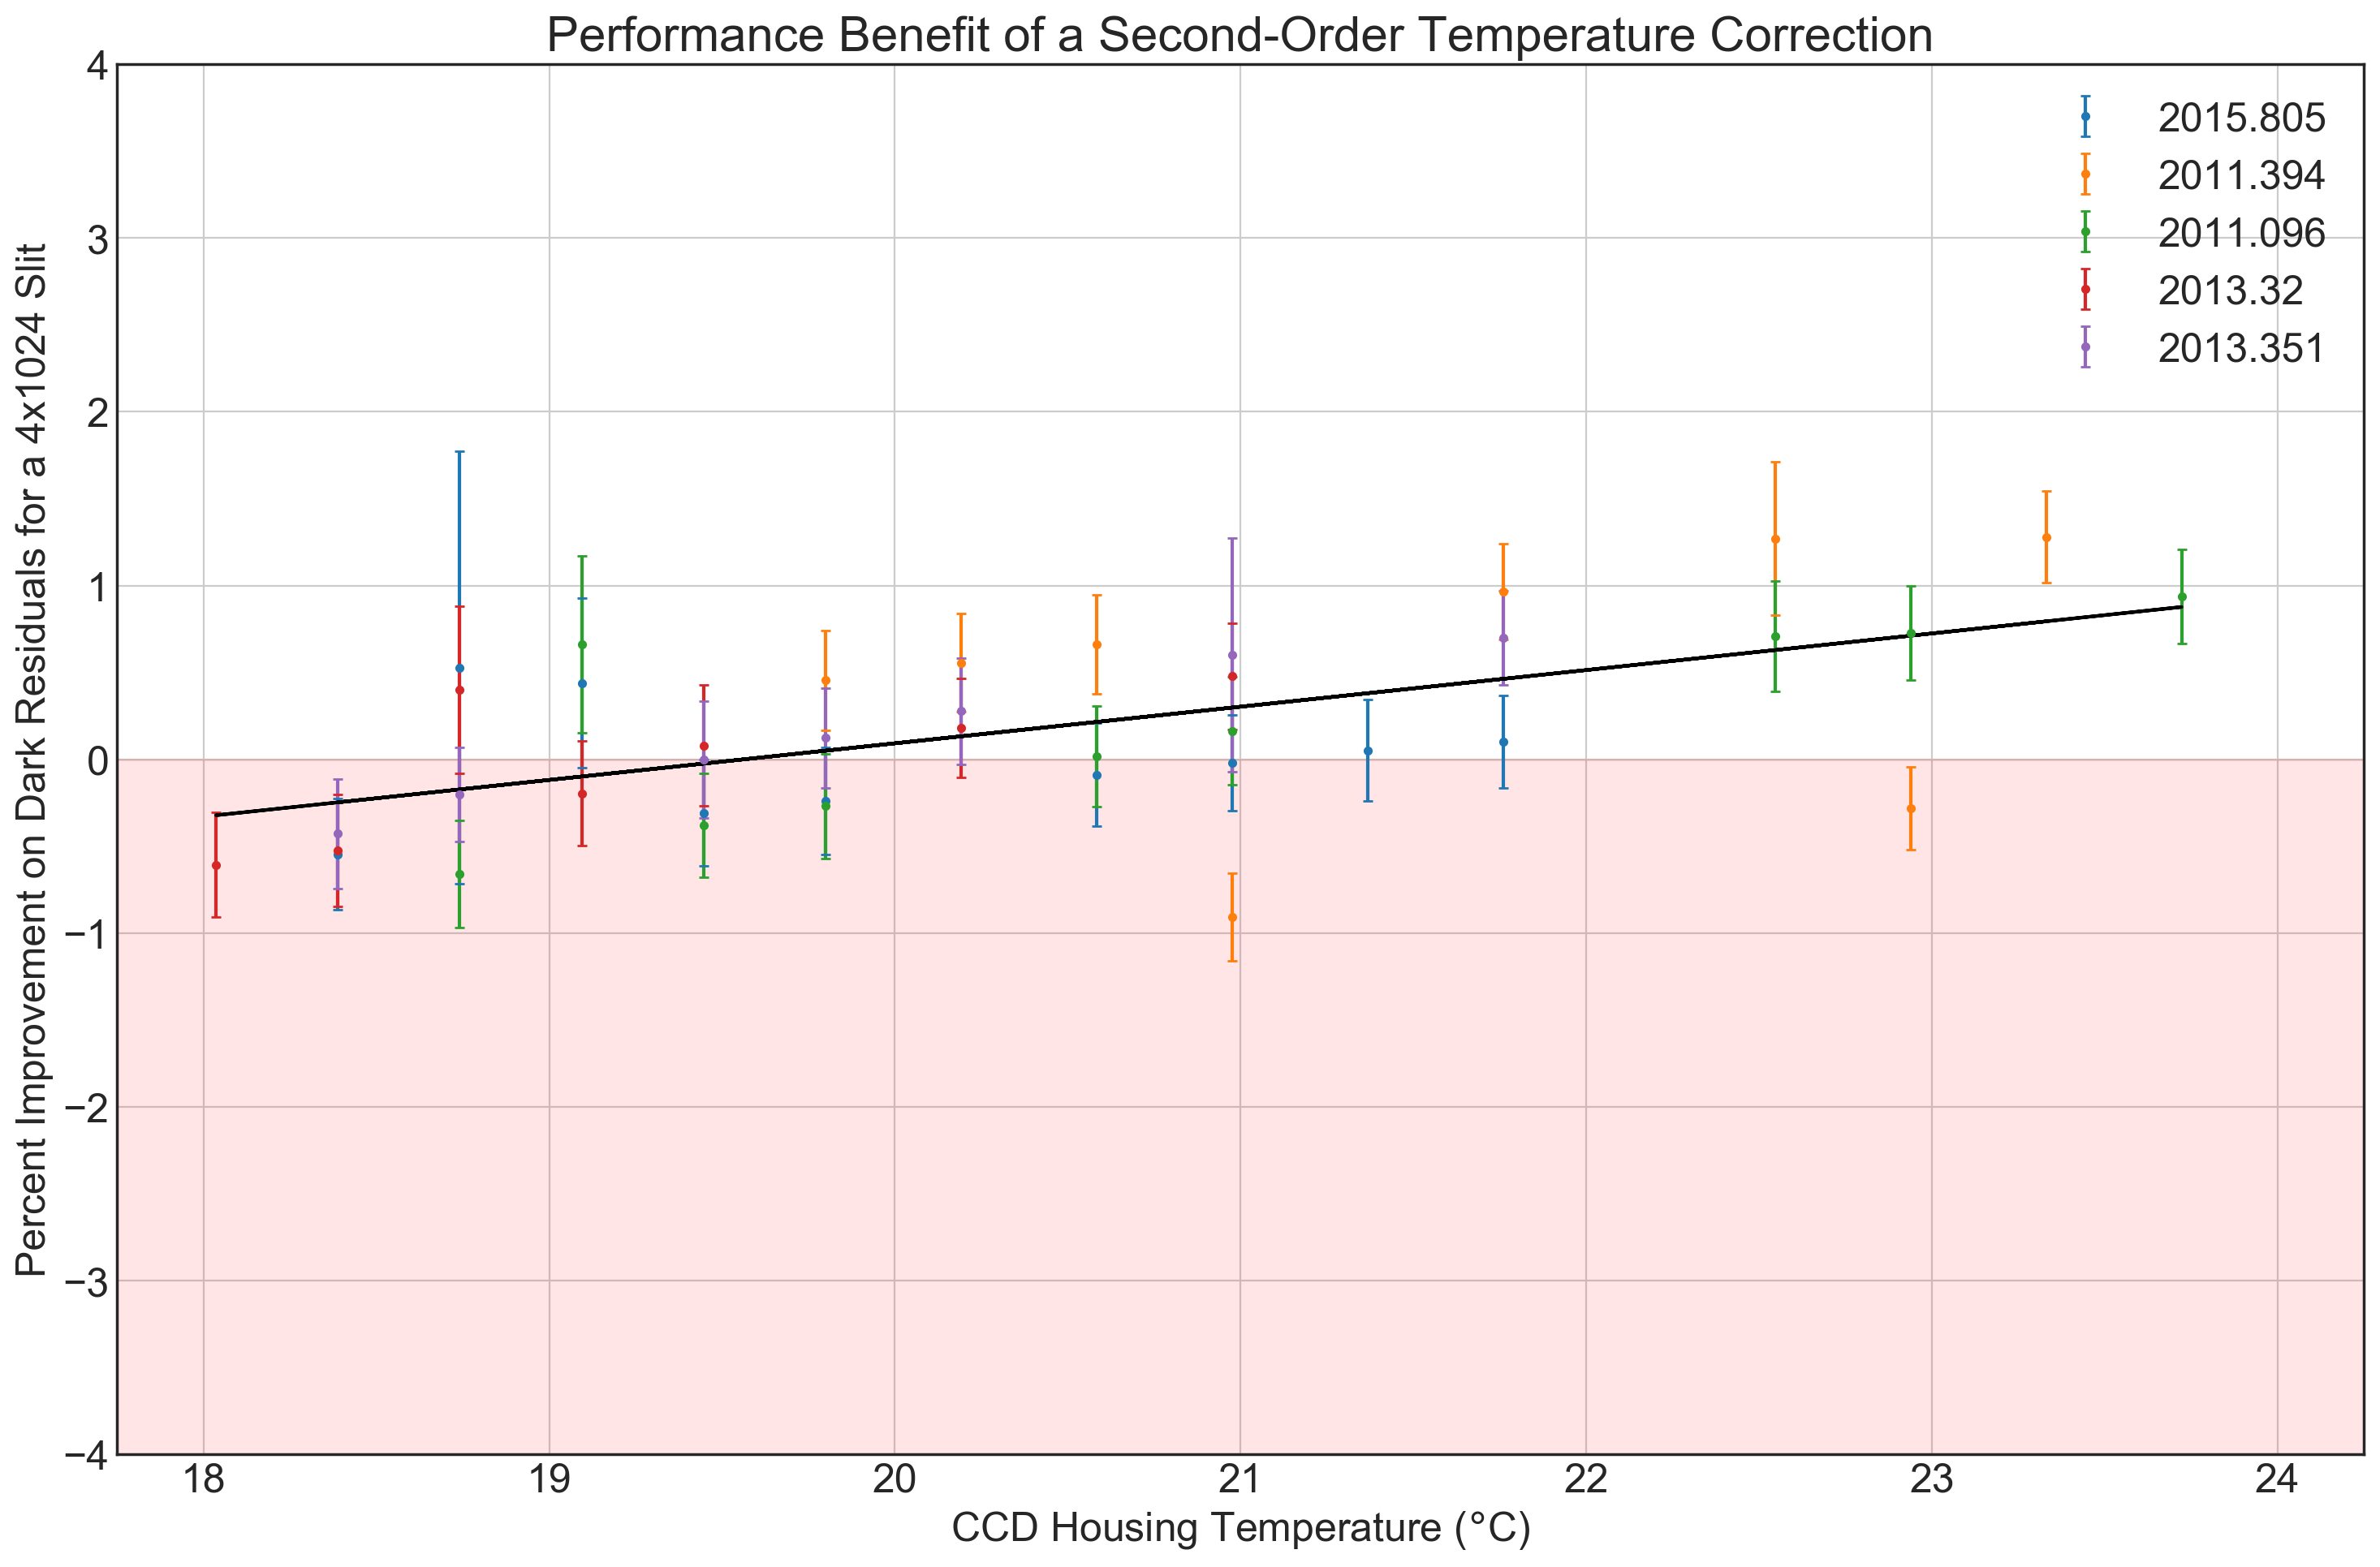

In [74]:
orig_ref_darks = ["02a19208o_drk.fits","v7i1156po_drk.fits","v471332so_drk.fits","x8c1626do_drk.fits",
                 "x8c1626fo_drk.fits"]

tweaked_ref_darks = ["/Users/dbranton/STIS/refstis/refstis/testdata/2015data/ocqq9ynpq_weekdark/02a19208o_drk_stand.fits",
                    "/Users/dbranton/STIS/refstis/refstis/testdata/2011data/weekdark_data/v7i1156po_drk_2nd.fits",
                    "/Users/dbranton/STIS/pixelhistory/corrtest/reffiles/v471332so_drk.fits",
                    "/Users/dbranton/STIS/refstis/refstis/testdata/2013data/wk2_weekdark/x8c1626do_drk.fits",
                    "/Users/dbranton/STIS/refstis/refstis/testdata/2013data/wk4_weekdark/x8c1626fo_drk.fits"]

data_dirs = ["/Users/dbranton/STIS/refstis/refstis/testdata/2015data/backup_flts/*flt.fits",
            "/Users/dbranton/STIS/refstis/refstis/testdata/2011data/backup_flts/*flt.fits",
            "/Users/dbranton/STIS/pixelhistory/corrtest/reffiles/sourcefiles/*flt.fits",
            "/Users/dbranton/STIS/refstis/refstis/testdata/2013data/backup_flts/*flt.fits",
            "/Users/dbranton/STIS/refstis/refstis/testdata/2013data/backup_flts/*flt.fits"]

REF_TEMP = 18.0
DRK_VS_T = 0.07

for params in csv.reader(open('sv_params.csv', 'r'),delimiter=' ',quoting=csv.QUOTE_NONNUMERIC):
    result_params = params
    
fig,ax = plt.subplots(1,1,figsize=(15,10))
fig.dpi=200

diff_all = []
temp_all = []
forder_all = []
sorder_all = []
err_all = []
for ref_dark,tweaked_ref_dark,data_dir in zip(orig_ref_darks,tweaked_ref_darks,data_dirs):
    
    tweaked_reffile = fits.open(tweaked_ref_dark)
    reffile = '/grp/hst/cdbs/oref/'+ref_dark
    orig_reffile = fits.open(reffile)
    
    temps = []
    diff = []
    err = []
    dark_temps = [float(fits.open(anneal_dark)[1].header['OCCDHTAV']) for anneal_dark in glob.glob(data_dir) 
                  if fits.open(anneal_dark)[0].header['DARKFILE'] == "oref$"+ref_dark]
    
    dark_files = ([anneal_dark for anneal_dark in glob.glob(data_dir) 
        if fits.open(anneal_dark)[0].header['DARKFILE'] == "oref$"+ref_dark])

    flt_srtd = [(float(temp),f) for temp,f in sorted(zip(dark_temps,dark_files))]
    
    #Group files of identical Housing Temperature
    stacked_files = []
    for key, grp in itertools.groupby(sorted(flt_srtd), key=operator.itemgetter(0)):
        stacked_files.append(list(map(operator.itemgetter(1), grp)))
        stacked_names = [fits.open(dark)[1].header['DATE-OBS'] for dark in stacked_files[-1]]
        stacked_temps = [fits.open(dark)[1].header['OCCDHTAV'] for dark in stacked_files[-1]]
        #print(key,stacked_temps, stacked_names)    
    
    for file_list in stacked_files:
        ATODGAIN = fits.open(file_list[0])[0].header['ATODGAIN']
        EXPTIME = fits.open(file_list[0])[0].header['TEXPTIME']
        OCCDHTAV = fits.open(file_list[0])[1].header['OCCDHTAV']
        
        #Retreive decimal year, exposure length and darkrates
        date = datetime.datetime(*[int(item) for item in fits.open(file_list[0])[1].header['DATE-OBS'].split('-')])
        startOfThisYear = datetime.datetime(year=date.year, month=1, day=1)
        startOfNextYear = datetime.datetime(year=date.year+1, month=1, day=1)
        yearElapsed = time.mktime(date.timetuple()) - time.mktime(startOfThisYear.timetuple())
        yearDuration = time.mktime(startOfNextYear.timetuple()) - time.mktime(startOfThisYear.timetuple())
        year = date.year + yearElapsed/yearDuration
        
        if len(file_list) > 1:
            data_list = [fits.open(dark)[1].data for dark in file_list]
            dark_data = np.median(data_list,axis = 0)
            err_list = [fits.open(dark)['ERR'].data for dark in file_list]
            dark_errdata = np.median(err_list,axis = 0)
        else:
            dark_data = fits.open(file_list[0])[1].data
            dark_errdata = fits.open(file_list[0])['ERR'].data
    


        
        orig_refdata = orig_reffile[1].data*EXPTIME/ATODGAIN
        orig_scaled = orig_refdata*(1+DRK_VS_T*(OCCDHTAV-REF_TEMP))
        orig_errdata = (orig_reffile['ERR'].data*EXPTIME/ATODGAIN)*(1+DRK_VS_T*(OCCDHTAV-REF_TEMP))
        
        
        
        
        
        tweaked_refdata = tweaked_reffile[1].data
        tweaked_errdata = tweaked_reffile['ERR'].data
        #These -------------------------------
        #dark_svrates = np.copy(dark_data)/EXPTIME*ATODGAIN 
        #dark_svrates = dark_svrates / (1 + (0.07)*(float(OCCDHTAV)-REF_TEMP))
        #Or This -----------------------------
        dark_svrates = np.copy(tweaked_refdata)
        #-------------------------------------
        dark_svrates[dark_svrates <=0] = 10**-3.0
        dark_svrates[dark_svrates >=10**1.0]= 10**1.0
        sv_matrix = np.array(compute_sv(result_params,np.log10(dark_svrates),year))
        tweaked_refdata = tweaked_refdata*EXPTIME/ATODGAIN
        tweaked_scaled = tweaked_refdata * (1+(sv_matrix)*(OCCDHTAV-REF_TEMP))
        tweaked_errdata = tweaked_errdata * (1+(sv_matrix)*(OCCDHTAV-REF_TEMP))
        


        #orig_darkdiff =(dark_data - orig_scaled)
        #tweaked_darkdiff = (dark_data - tweaked_scaled)

        n_row = 35 #35
        
        #dark_cutout = dark_data
        #orig_cutout = orig_scaled
        #tweak_cutout = tweaked_scaled
        
        dark_cutout = dark_data[n_row:n_row+4]
        orig_cutout = orig_scaled[n_row:n_row+4]
        tweak_cutout = tweaked_scaled[n_row:n_row+4]
        
        dark_err_cutout = dark_errdata[n_row:n_row+4]
        orig_err_cutout = orig_errdata[n_row:n_row+4]
        tweak_err_cutout = tweaked_errdata[n_row:n_row+4]
        

        sigma=5
        dark_sclip = sigma_clip(dark_cutout,sigma=sigma)
        dark_mask = np.ravel(dark_sclip).mask
        
        orig_sclip = sigma_clip(orig_cutout,sigma=sigma)
        orig_mask = np.ravel(orig_sclip).mask
        
        tweak_sclip = sigma_clip(tweak_cutout,sigma=sigma)
        tweak_mask = np.ravel(tweak_sclip).mask

        
        mask = orig_mask*tweak_mask*dark_mask
        
        dark_sum = np.sum(np.ravel(dark_cutout))/EXPTIME
        orig_sum = np.sum(np.ravel(orig_cutout))/EXPTIME
        tweak_sum = np.sum(np.ravel(tweak_cutout))/EXPTIME
        
        dark_err = np.sqrt(sum(map(lambda x:x*x,np.ravel(dark_err_cutout))))/EXPTIME
        orig_err = np.sqrt(sum(map(lambda x:x*x,np.ravel(orig_err_cutout))))/EXPTIME
        tweak_err = np.sqrt(sum(map(lambda x:x*x,np.ravel(tweak_err_cutout))))/EXPTIME
        
        #print(dark_sum,dark_err)
        orig_pdiff = ((orig_sum-dark_sum)/dark_sum) * 100
        tweak_pdiff = ((tweak_sum-dark_sum)/dark_sum) * 100
        
        orig_diff_err = np.sqrt(orig_err**2 + dark_err**2)
        tweak_diff_err = np.sqrt(tweak_err**2 + dark_err**2)
        
        
        orig_pdiff_err = abs(orig_pdiff) * np.sqrt((orig_diff_err/(orig_sum - dark_sum))**2 + (dark_err/dark_sum)**2)
        tweak_pdiff_err = abs(orig_pdiff) * np.sqrt((tweak_diff_err/(tweak_sum - dark_sum))**2 + (dark_err/dark_sum)**2)
        
        #orig_pdiff_err = abs(orig_pdiff) * np.sqrt((np.sqrt(orig_err**2+dark_err**2)/(orig_sum-dark_sum))**2 + (dark_err/dark_sum)**2)
        #tweak_pdiff_err = abs(tweak_pdiff) * np.sqrt((np.sqrt(tweak_err**2+dark_err**2)/(tweak_sum-dark_sum))**2 + (dark_err/dark_sum)**2)
        
        #print(orig_pdiff,orig_pdiff_err)
        temps.append(OCCDHTAV)
        #f_order.append(f_order_resid)
        #s_order.append(s_order_resid)
        delta_pdiff= abs(orig_pdiff)-(abs(tweak_pdiff))
        delta_pdiff_err = np.sqrt(orig_pdiff_err**2 + tweak_pdiff_err**2)
        diff.append(delta_pdiff)
        err.append(delta_pdiff_err)
        print(delta_pdiff,delta_pdiff_err)
        
        forder_all.append(abs(orig_pdiff))
        sorder_all.append(abs(tweak_pdiff))
        temp_all.append(OCCDHTAV)
        diff_all.append(delta_pdiff)
        err_all.append(delta_pdiff_err)
        #print(orig_pdiff,tweak_pdiff)
    
    ax.errorbar(temps,np.array(diff),err,fmt='.',label=str(np.round(year,3)),capsize=2)


linear_fit = np.polyfit(temp_all,diff_all,1)
p = np.poly1d(linear_fit)
ax.plot(temp_all,p(temp_all),color='k')
plt.legend()
ax.fill_between([15,25],-5,0,alpha=0.1,color='r')
ax.set_ylim(-4,4)
ax.set_xlim(17.75,24.25)
ax.set_ylabel("Percent Improvement on Dark Residuals for a 4x1024 Slit")
ax.set_xlabel(r"CCD Housing Temperature ($\degree$C)")
ax.grid()
ax.set_title("Performance Benefit of a Second-Order Temperature Correction")

plt.tight_layout()
#plt.savefig("Plots/slit_perf.png")

In [21]:
print(np.mean(forder_all))
print(np.mean(sorder_all))

11.9132816251
11.7458823349


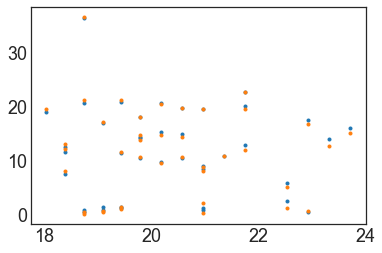

In [22]:
plt.plot(temp_all,forder_all,'.')
plt.plot(temp_all,sorder_all,'.')

In [23]:
flt = glob.glob("/Users/dbranton/STIS/refstis/refstis/testdata/2013data/backup_flts/*flt.fits")
fits.open(flt[0])[0].header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                   16 / number of bits per data pixel                  
NAXIS   =                    0 / number of data axes                            
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
ORIGIN  = 'HSTIO/CFITSIO March 2010' / FITS file originator                     
DATE    = '2017-06-24' / date this file was written (yyyy-mm-dd)                
NEXTEND =                    3 / Number of standard extensions                  
FILENAME= 'oc4u99e1q_flt.fits' / name of file                                   
FILETYPE= 'SCI      '          / type of data found in data file                
                                                                                
TELESCOP= 'HST'             

In [24]:
np.log10(0.15)

-0.82390874094431876

In [79]:
np.array([idx for idx,val in enumerate([1,3,5])])

array([0, 1, 2])

In [173]:
df = pd.read_csv("/Users/dbranton/science/cluster_fe_lines.csv")[['Wavelength','Ion','eP','Log-gf','5125']]
m = np.isnan(df['5125']) == False
mask = [row.all() for row in (df.where(m,df)  == df.mask(~m, df)).values]
df[mask]

,Wavelength,Ion,eP,Log-gf,5125
0,5307.36,26.0,1.61,-2.99,136.20
1,5322.04,26.0,2.28,-2.80,99.20
3,5466.99,26.0,3.57,-2.23,57.80
4,5491.83,26.0,4.19,-2.19,33.30
5,5522.45,26.0,4.21,-1.56,64.00
6,5536.58,26.0,2.83,-3.81,24.80
7,5539.28,26.0,3.64,-2.66,47.10
8,5560.21,26.0,4.44,-1.19,71.80
9,5577.03,26.0,5.03,-1.55,17.80
10,5607.66,26.0,4.15,-2.27,32.30


In [101]:
'4250red'[:-3]

'4250'

In [158]:
np.array([True,True]).all()

True

In [165]:
df['badkey']

KeyError: 'badkey'